In [1]:
##import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
##arraay to store object & image point
objpoints = []
imgpoints= []

In [3]:
#generate object points
objb= np.zeros((6*9,3), np.float32)
objb[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2) #x,y coordinates only

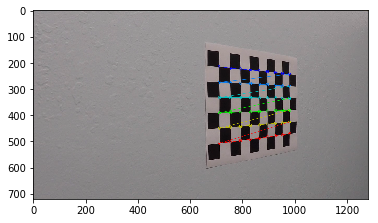

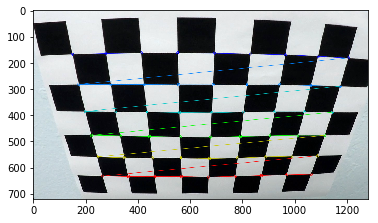

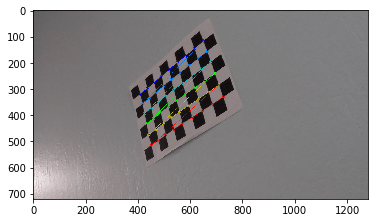

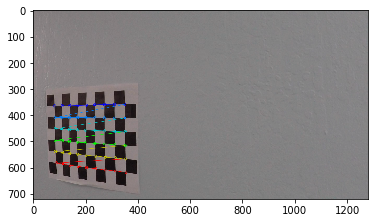

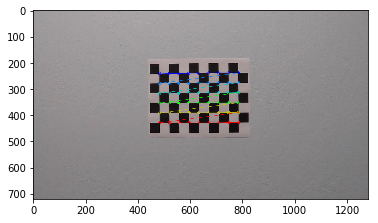

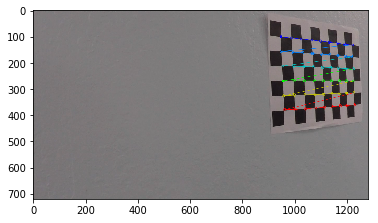

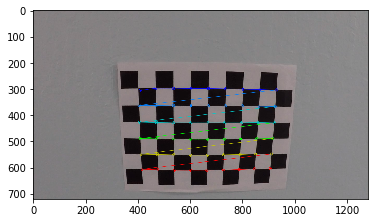

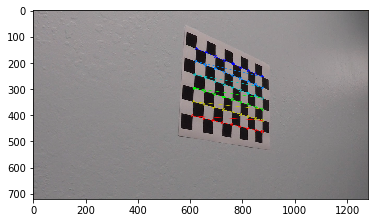

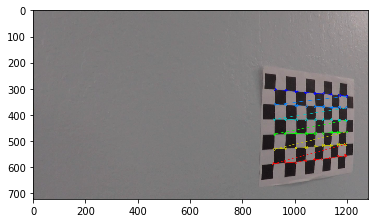

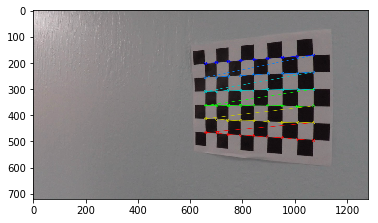

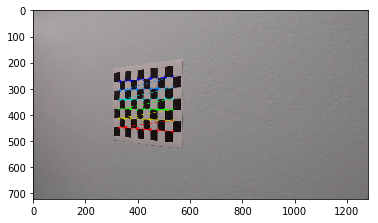

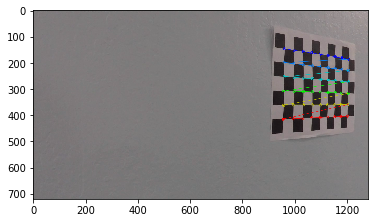

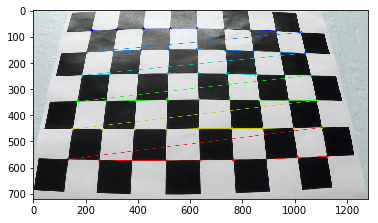

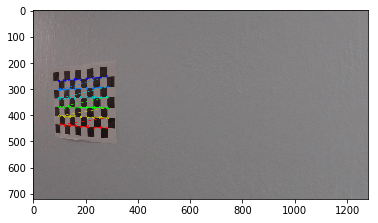

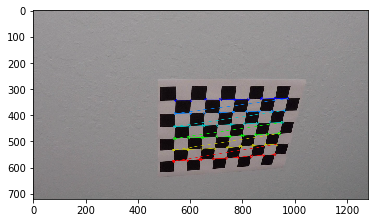

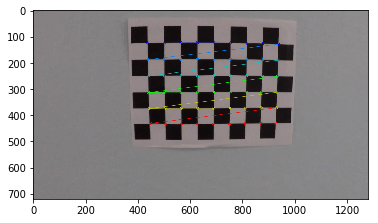

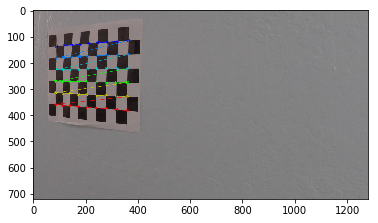

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')
for im in images:
    img=cv2.imread(im)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) #find chess points (image points)
    if ret==True:
        objpoints.append(objb)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.show()

In [5]:
def cal_undist(img, objpoints , imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

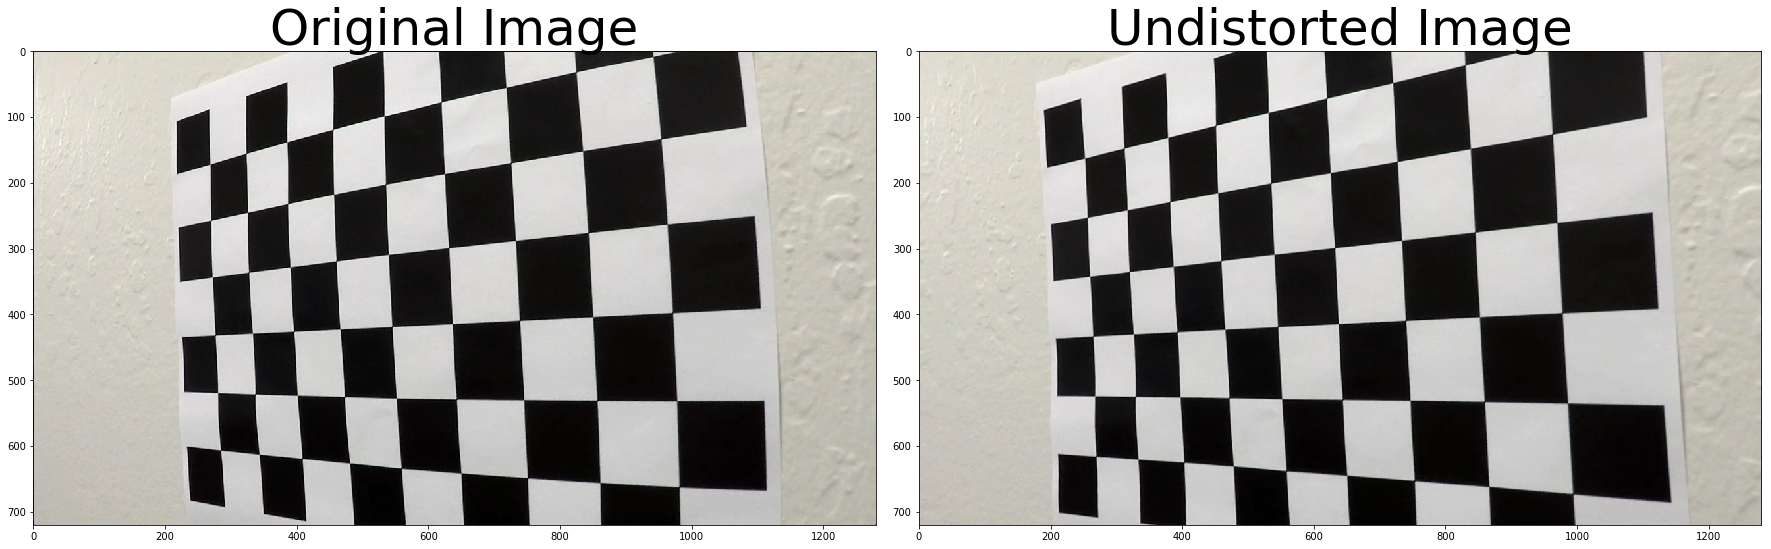

In [6]:
img=mpimg.imread("camera_cal/calibration4.jpg")
undistorted = cal_undist(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

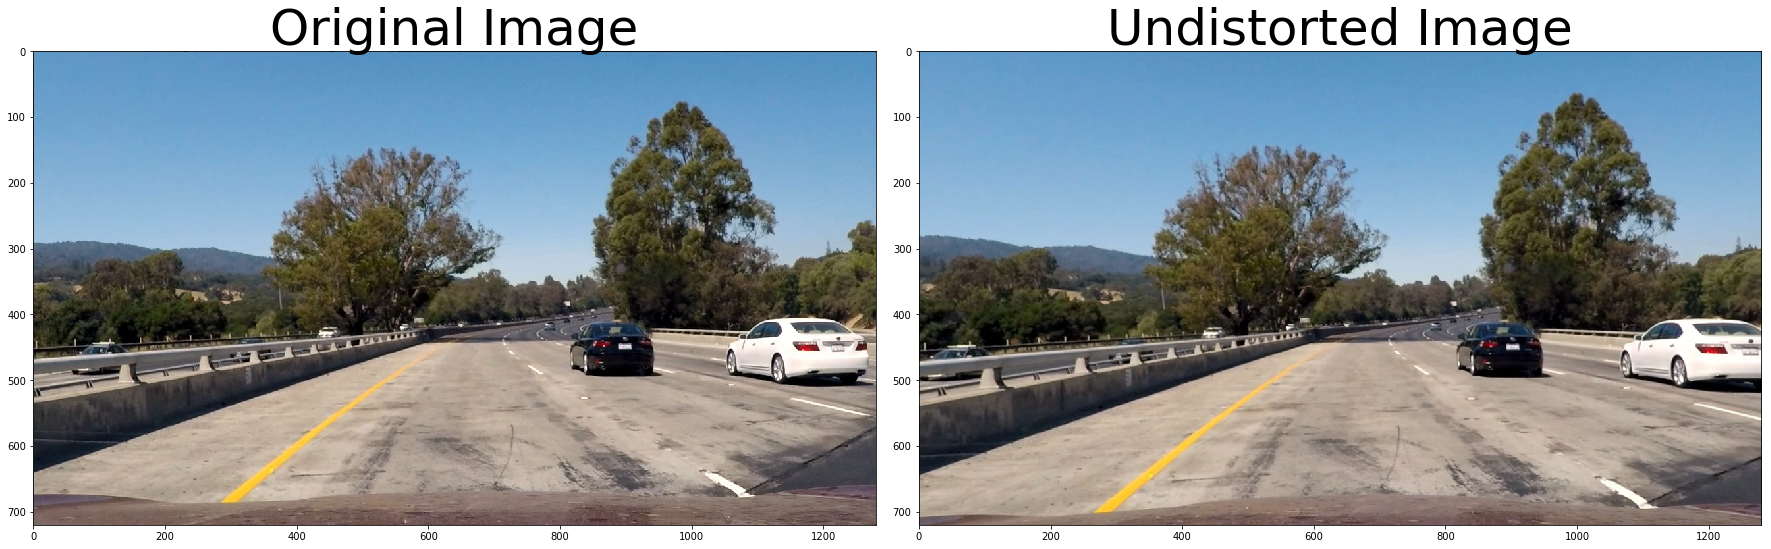

In [7]:
test1=mpimg.imread("test_images/test1.jpg")
undist1= cal_undist(test1,objpoints,imgpoints)
test2=mpimg.imread("test_images/test2.jpg")
undist2= cal_undist(test2,objpoints,imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist1)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def sobel(img,threshold):
    abs_sobel=np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=threshold[0]) & (scaled_sobel<=threshold[1])]=1
    return binary_output
    

In [9]:
def mag_threshold(img,threshold,kernel):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [10]:
def hls_select(img, thresh=(120, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


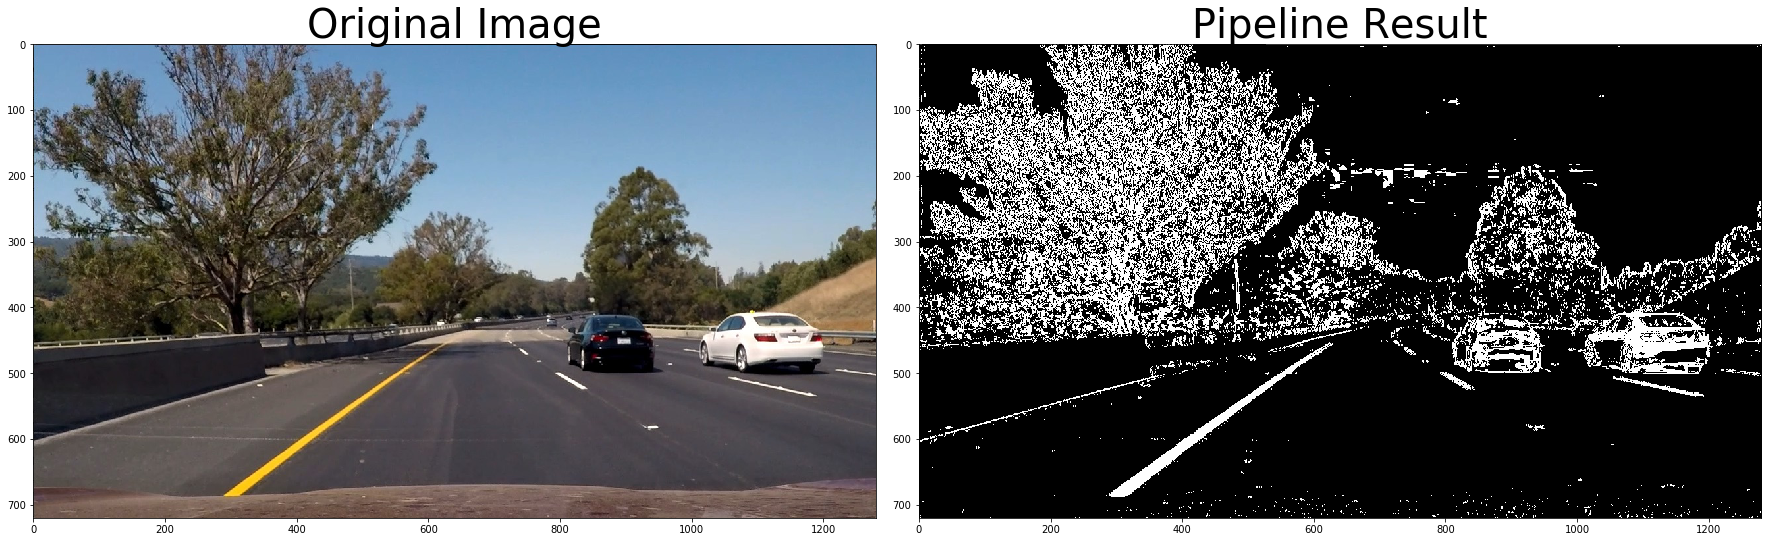

In [11]:
def combine(img, s_thresh=(120, 255), sx_thresh=(15, 100)):
    img=np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    sxbinary=sobel(l_channel,sx_thresh)
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

original=mpimg.imread("test_images/test6.jpg")
result = combine(original)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(original)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

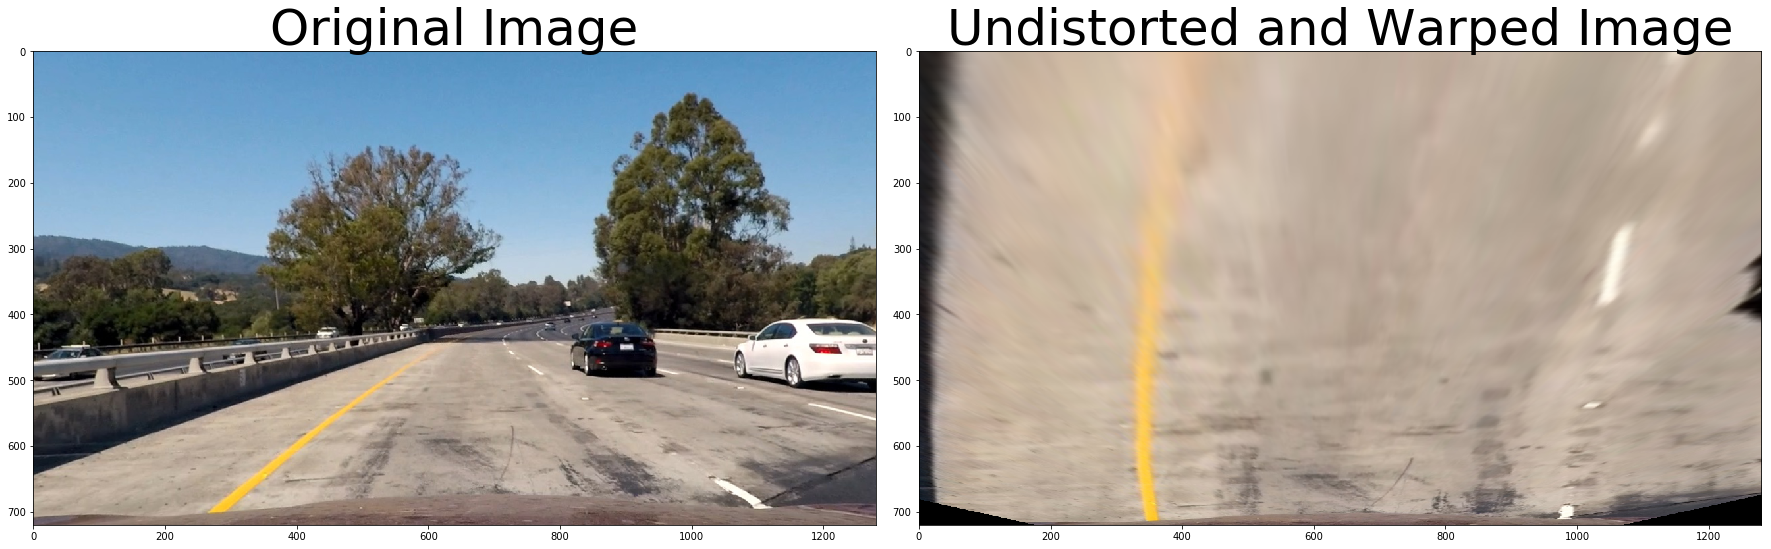

In [12]:
def warper(img):
    #get the width and the height of the image
    h=img.shape[0]
    w=img.shape[1]
    
    
    src = np.float32([
    (585, 460), # Top-left corner
    (203, 720), # Bottom-left corner
    (1127, 720), # Bottom-right corner
    (695, 460) # Top-right corner
    ])
    
    dst = np.float32([
    (320, 0), # Top-left corner
    (320, 720), # Bottom-left corner
    (960, 720), # Bottom-right corner
    (960, 0) # Top-right corner
     ])
    #calculate perspective transform matrix
    M=cv2.getPerspectiveTransform(src,dst)
    #warp the image
    warped=cv2.warpPerspective(img,M,(w,h))
    return warped,M

top_down, perspective_M = warper(undist1)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undist1)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    


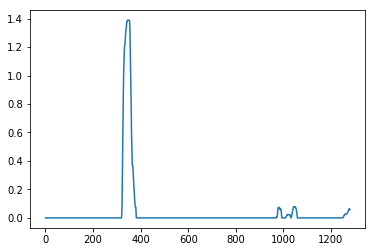

In [13]:
def histogram(img):
    #normalize the image
    img=img/255
    #work with the bottom half of the warped image
    bottom_half=img[img.shape[0]//2:,:]
    #sum the pixels vertically
    histogram=np.sum(bottom_half,axis=0)
    return histogram
img=hls_select(undist1)
warped, perspective_M=warper(img)
hist=histogram(warped)

plt.plot(hist)
#plt.imshow(wraped,cmap='gray')

In [55]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



In [56]:
def fit_poly(binary_warped,leftx, lefty, rightx, righty):
    
     ###Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

   
    return left_fitx, right_fitx, ploty,left_fit,right_fit

In [57]:
def fit_poly1(binary_warped,leftx, lefty, rightx, righty):
    
     ###Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
   
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
   
    return left_fitx, right_fitx, ploty

In [58]:
def searcharoundpoly(binary_warped,left_fit,right_fit):
    
    #hyperparameter
    margin=100
    #get the activited pixels
    nonzero=binary_warped.nonzero()
    nonzeroy=np.array(nonzero[0])
    nonzerox=np.array(nonzero[1])
    #create search area
    left_lane_inds = ((nonzerox>(left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2]-margin)) & (nonzerox<(left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2]+margin)))
    right_lane_inds = ((nonzerox>(right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2]-margin)) & (nonzerox<(right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2]+margin)))
    #extract left and right line pixel position
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #fit polynomial
    left_fitx1, right_fitx1, ploty1 = fit_poly1(binary_warped,leftx, lefty, rightx, righty)
        # Create an image to draw on and an image to show the selection window
    """"out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    #window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    #left_line_window1 = np.array([np.transpose(np.vstack([left_fitx1-margin, ploty1]))])
    #left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx1+margin, 
                              ploty1])))])
    #left_line_pts = np.hstack((left_line_window1, left_line_window2))
    #right_line_window1 = np.array([np.transpose(np.vstack([right_fitx1-margin, ploty1]))])
    #right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx1+margin, 
                              ploty1])))])
    #right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##"""
    
    return left_fitx1, right_fitx1, ploty1
    

In [59]:
def measure_curvature(ploty, left_fit, right_fit):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

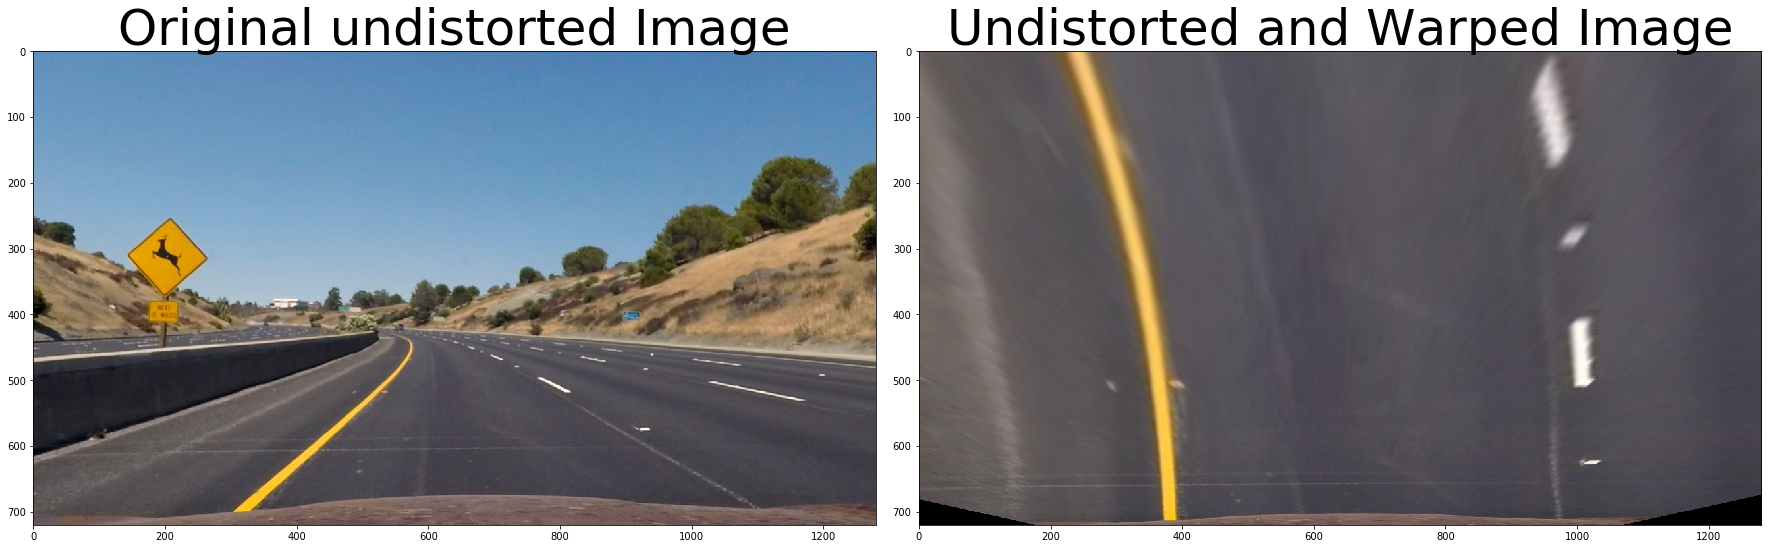

In [60]:
final_test= mpimg.imread("test_images/test2.jpg")
final_undist=cal_undist(final_test,objpoints,imgpoints)
final_warped,M=warper(final_undist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(final_undist)
ax1.set_title('Original undistorted Image', fontsize=50)
ax2.imshow(final_warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

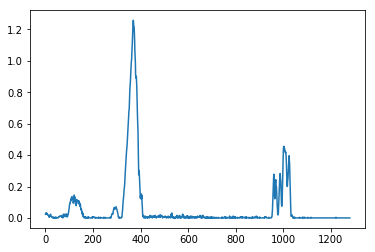

In [61]:
final_hls=combine(final_undist)
final_warp,M=warper(final_hls)
h=histogram(final_warp)
plt.plot(h)


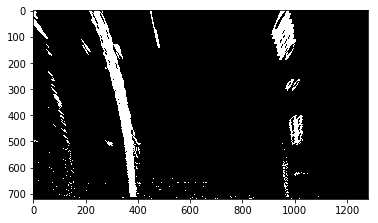

In [62]:
plt.imshow(final_warp,cmap='gray')

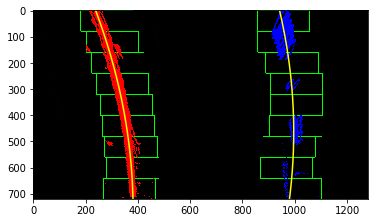

In [63]:
leftx, lefty, rightx, righty, out_img=find_lane_pixels(final_warp)
left_fitx, right_fitx, ploty, left_fit,right_fit = fit_poly(final_warp,leftx, lefty, rightx, righty)
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

plt.imshow(out_img)

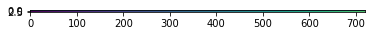

In [64]:
result=searcharoundpoly(final_warp,left_fit, right_fit)
plt.imshow(result)

In [65]:
left_curverad, right_curverad= measure_curvature(ploty, left_fit,right_fit)
print(left_curverad, 'm', right_curverad, 'm')

2444.56736222 m 2140.48139801 m


In [66]:
def offset(left_fitx,right_fitx,warped):
    #calculate the center between two fit
    center=(right_fitx[-1]+left_fitx[-1])/2
    xm_per_pix = 3.7/700
    #calculate the offset  of the lane center from the center of the image converted to meters
    center = (center-warped.shape[1]/2)*xm_per_pix
    #distance=distance*xm_per_pix
    return center
center=offset(left_fitx,right_fitx,final_warp)
print(center)


0.214696372269


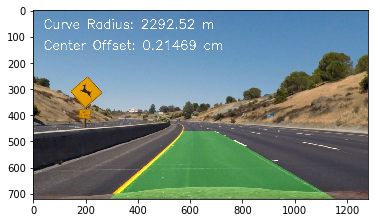

In [67]:
def project_image(original,left_fitx,right_fitx,ploty,warped,Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
# Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    return result

src = np.float32([
    (585, 460), # Top-left corner
    (203, 720), # Bottom-left corner
    (1127, 720), # Bottom-right corner
    (695, 460) # Top-right corner
    ])
    
dst = np.float32([
    (320, 0), # Top-left corner
    (320, 720), # Bottom-left corner
    (960, 720), # Bottom-right corner
    (960, 0) # Top-right corner
     ])    
Minv=cv2.getPerspectiveTransform(dst,src)
result=project_image(final_undist,left_fitx,right_fitx,ploty,final_warp,Minv)
cv2.putText(result,'Curve Radius: '+str((left_curverad+right_curverad)/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,'Center Offset: '+str(center)[:7]+' cm',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
plt.imshow(result)

In [68]:
def pipeline(img):
    undist=cal_undist(img,objpoints,imgpoints)
    thresholded=combine(undist)
    final_warped,M=warper(thresholded)
    leftx, lefty, rightx, righty, out_img=find_lane_pixels(final_warped)
    left_fitx, right_fitx, ploty, left_fit,right_fit = fit_poly(final_warped,leftx, lefty, rightx, righty)
    left_curverad, right_curverad = measure_curvature(ploty, left_fit, right_fit)
    center=offset(left_fitx,right_fitx,final_warped)
    left_fitx1, right_fitx1, ploty1= searcharoundpoly(final_warped,left_fit,right_fit)
    
    s = np.float32([
    (585, 460), # Top-left corner
    (203, 720), # Bottom-left corner
    (1127, 720), # Bottom-right corner
    (695, 460) # Top-right corner
    ])
    
    d = np.float32([
    (320, 0), # Top-left corner
    (320, 720), # Bottom-left corner
    (960, 720), # Bottom-right corner
    (960, 0) # Top-right corner
     ])    
    Minv=cv2.getPerspectiveTransform(d,s)
    
    result = project_image(img,left_fitx,right_fitx,ploty,final_warped,Minv)
    cv2.putText(result,'Curve Radius: '+str((left_curverad+right_curverad)/2)[:7]+' m',(40,70), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Center Offset: '+str(center)[:7]+' m',(40,150), cv2.FONT_HERSHEY_SIMPLEX, 1.6,(255,255,255),2,cv2.LINE_AA)
    
    return result
    
    

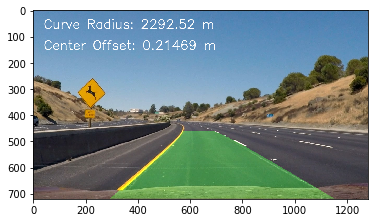

In [69]:
result= pipeline(final_test)
plt.imshow(result)

In [70]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = 'output_images/solidWhiteRight.mp4'
clip1 = VideoFileClip("project_video.mp4")
clip = clip1.fl_image(pipeline)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/solidWhiteRight.mp4
[MoviePy] Writing video output_images/solidWhiteRight.mp4



100%|█████████▉| 1260/1261 [32:15<00:01,  1.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/solidWhiteRight.mp4 

CPU times: user 30min 6s, sys: 3.19 s, total: 30min 9s
Wall time: 32min 18s


In [71]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [72]:
output1 = 'output_images/challenge.mp4'
clip2 = VideoFileClip("challenge_video.mp4")
clip3 = clip2.fl_image(pipeline)
%time clip3.write_videofile(output1, audio=False)

[MoviePy] >>>> Building video output_images/challenge.mp4
[MoviePy] Writing video output_images/challenge.mp4


100%|█████████▉| 484/485 [12:15<00:01,  1.59s/it]WARNING:py.warnings:/opt/conda/lib/python3.6/site-packages/moviepy/video/io/ffmpeg_reader.py:132: UserWarning: Warning: in file challenge_video.mp4, 2764800 bytes wanted but 0 bytes read,at frame 484/485, at time 16.15/16.15 sec. Using the last valid frame instead.
  UserWarning)

100%|██████████| 485/485 [12:16<00:00,  1.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge.mp4 

CPU times: user 11min 29s, sys: 1.18 s, total: 11min 31s
Wall time: 12min 19s


In [73]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output1))

In [78]:
output2 = 'output_images/harder_challenge.mp4'
clip3 = VideoFileClip("harder_challenge_video.mp4")
clip4 = clip3.fl_image(pipeline)
%time clip4.write_videofile(output2, audio=False)

[MoviePy] >>>> Building video output_images/harder_challenge.mp4
[MoviePy] Writing video output_images/harder_challenge.mp4


100%|█████████▉| 1199/1200 [31:49<00:01,  1.57s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge.mp4 

CPU times: user 29min 8s, sys: 10.1 s, total: 29min 18s
Wall time: 31min 53s


In [79]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))